In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque
import random
import pygame
from tqdm import tqdm

try:
    import gym
except ImportError:
    %pip install gym
    import gym


pygame 2.5.2 (SDL 2.28.3, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
sns.set_theme(style='whitegrid')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # else gives error when trying to plot
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('Using device:', device)

Using device: cpu


## Define Environment by Gymnasium

[Environment Details](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Full Example on Github of the [Mountain Car](https://github.com/guillaumefrd/q-learning-mountain-car)

In [5]:
env = gym.make('MountainCar-v0', render_mode='human')

In [6]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)


#### <span style="text-decoration:underline;">Explanations:</span>
- Observation space:
    - [-1.2 0.6] position range (in m)
    - [-0.07 0.07] velocity range (in v = m/s)
    - 2dim phase space (x-v-space)
- Actions:
    - 0: Accelerate to left
    - 1: Don't accelerate
    - 2: Accelerate to right
### <span style="text-decoration:underline;">Transition dynamics:</span>
<span style="text-decoration:underline;">Variables:</span>

Force $F$, action $a$, position $x$, velocity $v$, time (discrete) $t$, gravity $g$

The transition dynamics then reads:
$$
\begin{align}
v_{t+1} &= v_t + (a - 1)F - \cos(3x_t)g\\ 
x_{t+1} &= x_t + v_{t+1}
\end{align}
$$

Physical explanation:
- $ (a - 1) \implies$: -1: left, 0; no acceleration; +1: right acceleration; magnitude $F$
- Physically, the dimensions are an acceleration (setting $m=1$ and having a force balance of $\Delta v = v_{t+1}-v_t$)
- The last term is gravitational force, where the angle is expressed as $\alpha=3x$

#### <span style="text-decoration:underline;">Notes</span>
- From what I've seen the default reward setting is -1 per time step where the goal yields 0 reward
- Environment acts stochastically -> require to define bins for space / velocity to assort values to a state

#### Define the general functions

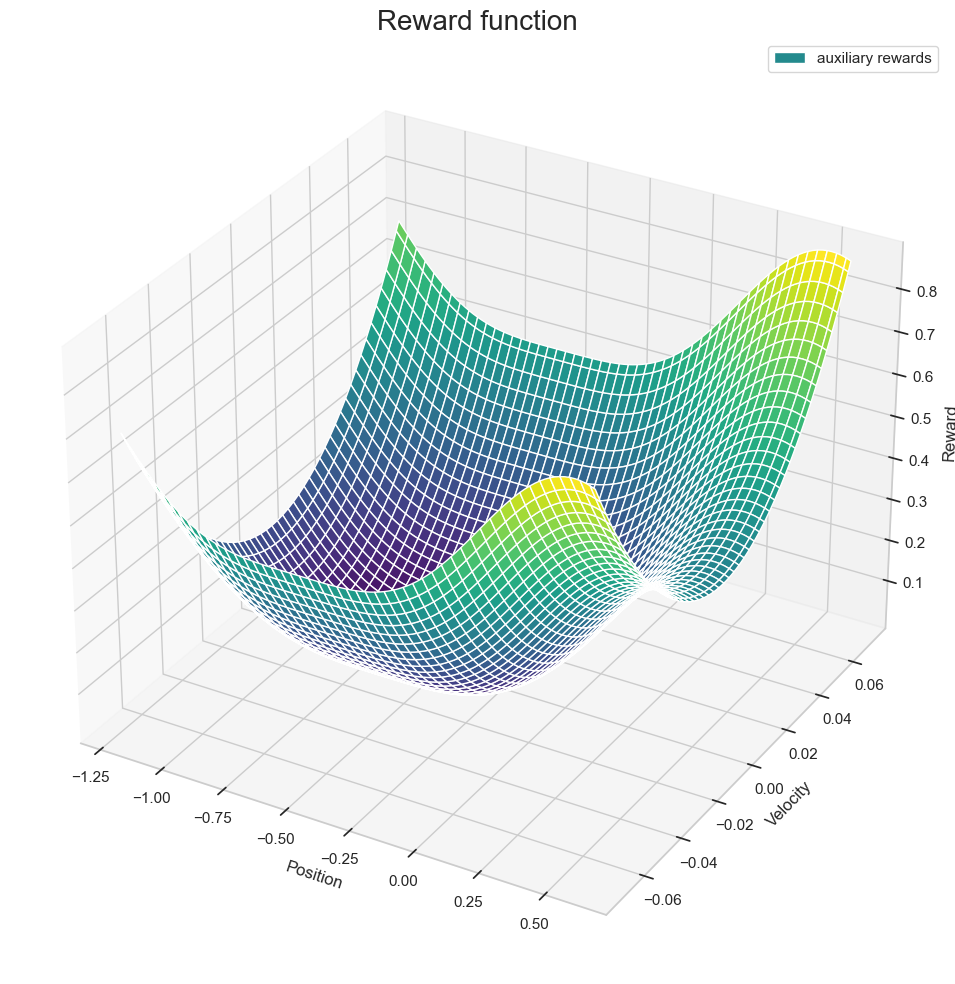

In [7]:
# To display the rewards per position and velocity
# The issue is to find proper scaling between position and velocity reward, because time seems strangely scaled
# in the sense that velocity is always quite low each time step and position is always quite high
x = np.linspace(-1.2, 0.6, 100)
y = np.linspace(-0.07, 0.07, 100)
X, Y = np.meshgrid(x, y)
Z = (np.sin(3 * X) + 1) ** 2 * 0.1 + Y ** 2 *100
Z_env = Z.copy()


# add environment reward -1 everywhere where x < 0.5
#Z_env[X < 0.5] -= 1


fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, Z_env, cmap='viridis', label='total rewards')
ax.plot_surface(X, Y, Z, cmap='viridis', label='auxiliary rewards')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Reward')
ax.set_title('Reward function', fontsize=20)

plt.legend()
plt.tight_layout()

In [8]:
# Experiment with different rewards (very high / low)
def domain_based_reward(state):
    """
    Return the position of the car as the reward (between -1.2 and 0.6)
    :param state: the current state of the environment
    :return: the reward
    """
    # reward the total energy, see Transition dynamics for details of equation.
    # Downscale magnitude to ensure goal state yields highest reward still
    # NOTE: potential energy is based on harmonic oscillator
    position = state[0]
    velocity = state[1]
    return ((np.sin(3* (position)) + 1) ** 2 * 1e-1 + velocity ** 2 * 1e2)

In [9]:
def run(agent, episodes, max_episode_steps=None, render=False, reward_function=None):
    """
    Run the Agent through the environment
    :param episodes: number of episodes to run the algorithm
    :param max_episode_steps: maximum number of steps in an episode
    :param render: boolean to render the environment or not
    :param reward_function: function to compute the current reward. Can be either "domain-based" or "non-domain-based" or None. If another string is passed, acts as None.
    :return: training_stats: dictionary containing the training statistics:
        - episodes_lengths: the length of each episode
        - episodes_mean_loss: the mean loss of each episode
        - episodes_environment_rewards: the environment reward of each episode
        - episodes_auxiliary_rewards: the auxiliary reward of each episode
        - episodes_rewards: the total reward of each episode
        - num_successes: the number of episodes that reached the goal
    """

    # load the environment
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # storage variables
    episodes_lengths = []
    episodes_mean_loss = []
    episodes_environment_rewards = []
    episodes_auxiliary_rewards = []
    episodes_rewards = []
    num_successes = 0

    total_steps = 0

    for _ in tqdm(range(episodes)):
        # reset episode and episode's statistics
        state, _ = env.reset()
        episode_environment_reward = 0.0
        episode_auxiliary_reward = 0.0
        episode_reward = 0.0
        episode_loss = 0.0

        terminated = False
        truncated = False
        episode_steps = 0

        while not terminated and (not truncated if not max_episode_steps else episode_steps < max_episode_steps):
            # select and take action based on agent's policy
            action = agent.select_action(state, total_steps)
            next_state, environment_reward, terminated, truncated, _ = env.step(action)

            # apply the reward function
            if reward_function == "domain-based":
                auxiliary_reward = domain_based_reward(next_state) 
            else:
                auxiliary_reward = 0

            reward = environment_reward + auxiliary_reward

            # store in replay buffer
            agent.observe(state, action, next_state, reward, terminated)

            # update the agent and get the loss 
            loss = agent.update(total_steps)

            # update state
            state = next_state

            # add rewards and loss
            episode_environment_reward += environment_reward
            episode_auxiliary_reward += auxiliary_reward
            episode_reward += reward
            episode_loss += loss

            # increase the steps counters
            episode_steps += 1
            total_steps += 1

            # record success
            if terminated:
                num_successes += 1

        # save the best policy network
        if episodes_rewards and episode_reward >= max(episodes_rewards):
            agent.save()

        # store the training statistics
        episodes_lengths.append(episode_steps)
        episodes_mean_loss.append(episode_loss / episode_steps)
        episodes_environment_rewards.append(episode_environment_reward)
        episodes_auxiliary_rewards.append(episode_auxiliary_reward)
        episodes_rewards.append(episode_reward)

    env.close()

    training_stats = {
        "episodes_lengths": episodes_lengths,
        "episodes_mean_loss": episodes_mean_loss,
        "episodes_environment_rewards": episodes_environment_rewards,
        "episodes_auxiliary_rewards": episodes_auxiliary_rewards,
        "episodes_rewards": episodes_rewards,
        "num_successes": num_successes
    }

    return training_stats

## First steps
- Initialise a random Agent to take random movements
- save duration for each episode -> reward count can be used for this
- Define a run function, to run an agent for $x$ episodes in the environment and to select training and / or rendering

In [10]:
class RandomAgent:
    def __init__(self):
        self.action_space = env.action_space
        self.observation_space = env.observation_space

    def observe(self, state, action, next_state, reward, terminated):
        pass

    def select_action(self, state, steps):
        return self.action_space.sample()  # take a random action

    def update(self, steps):
        return 0  # return 0 for loss to avoid error

    def save(self):
        pass

#### Run the random agent for an episode and render it

In [11]:
random_agent = RandomAgent()
_ = run(random_agent, 1, render=True)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Lione\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1/1 [00:07<00:00,  7.61s/it]


#### Run the random Agent 100 times and plot the lengths of the episodes for different max lengths.

100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


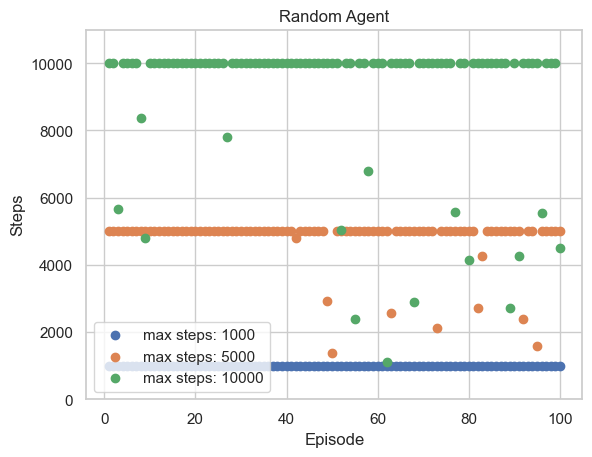

In [12]:
# run the random Agent 100 times and plot rewards
random_agent = RandomAgent()
max_episode_lengths = [1000, 5000, 10000]
episode_lengths = [] # why need this list?

fig, ax = plt.subplots()

for max_episode_length in max_episode_lengths:
    training_stats= run(random_agent, 100, max_episode_steps=max_episode_length)
    episode_lengths.append(training_stats['episodes_lengths'])

    # plot steps taken of current episode
    ax.scatter(np.arange(1, 101), training_stats['episodes_lengths'], label=f'max steps: {max_episode_length}')

#ax.hlines(np.abs(5000), 0, 100, colors='red', linestyles='dashed', label='threshold') --> In case we want to plot a threshold line
ax.set(xlabel='Episode', ylabel='Steps', title='Random Agent', ylim=(0, 11000))

plt.legend(loc='lower left')
plt.savefig('Random_Agent_varyin.png')
plt.show()

## Define NN class, to initialise for DQN with tunable hidden layers and neuron number

In [13]:
# Define Network class for DQN with 1 hidden layer and relu activation
class DQN(nn.Module):
    def __init__(self, input_states, out_actions, hidden_layers=2, hidden_nodes=64):
        super(DQN, self).__init__()

        self.hidden_layers = nn.ModuleList([nn.Linear(input_states, hidden_nodes)])
        self.hidden_layers.extend([nn.Linear(hidden_nodes, hidden_nodes) for _ in range(hidden_layers - 1)])
        self.out = nn.Linear(hidden_nodes, out_actions)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.out(x)
        return x

## Define DQN Agent

In [14]:
class DQNAgent:
    def __init__(self, trainable: bool, save_name: str, gamma=0.99, epsilon=0.9, epsilon_decay=1000, epsilon_min=0.05,
                 batch_size=64, learning_rate=0.001, sync_rate=1000, optimizer=optim.AdamW):
        # Initialize agent
        self.trainable = trainable
        self.save_name = save_name
        self.action_space = env.action_space
        self.replay_buffer = deque([], maxlen=10000)  # replay buffer with fixed size of 10000
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay  # decaying rate of epsilon
        self.epsilon_min = epsilon_min  # minimum value of epsilon
        self.gamma = gamma  # discount factor
        self.batch_size = batch_size  # batch size for training
        self.sync_rate = sync_rate  # rate at which to sync target network with policy network  
        self.loss = nn.MSELoss()  # loss function 

        # Initialize Q-networks separately otherwise we update both networks 
        self.policy_net = DQN(input_states=env.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)
        self.target_net = DQN(input_states=env.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)
        if not trainable:  # load the best network 
            self.policy_net.load_state_dict(torch.load(f'{self.__class__.__name__}_{save_name}.pth'))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate)

        # Track loss
        self.losses = []

    def observe(self, state, action, next_state, reward, terminated):
        # Update agent's internal memory with observed transition
        self.replay_buffer.append((state, action, next_state, reward, terminated))

    def select_action(self, state, steps):
        # Select action based on epsilon-greedy policy -> returns action

        # exponentially decaying epsilon
        exploration_prob = max(self.epsilon * np.exp(-steps / self.epsilon_decay), self.epsilon_min)
        if np.random.rand() < exploration_prob and self.trainable:
            action = self.action_space.sample()
        else:
            with torch.no_grad():  # no need to calculate gradients
                state_tensor = torch.tensor(state, device=device)
                action = torch.argmax(
                    self.policy_net(state_tensor)).item()  # exploit with probability 1-epsilon from policy network
        return action

    def update(self, steps):
        # Update agent's policy based on observed transitions
        batch_loss = 0

        # sample mini-batch from memory, don't use for loop
        if len(self.replay_buffer) > self.batch_size and self.trainable:
            mini_batch = random.sample(self.replay_buffer, self.batch_size)

            # unpack mini-batch
            states = torch.tensor([transition[0] for transition in mini_batch], dtype=torch.float, device=device)
            actions = torch.tensor([transition[1] for transition in mini_batch], dtype=torch.long, device=device)
            next_states = torch.tensor([transition[2] for transition in mini_batch], dtype=torch.float, device=device)
            rewards = torch.tensor([transition[3] for transition in mini_batch], dtype=torch.float, device=device)
            terminated = torch.tensor([transition[4] for transition in mini_batch], dtype=torch.bool, device=device)

            with torch.no_grad():
                # calculate target values
                Q_target = torch.zeros(rewards.shape, device=device)
                # solves the issue of terminal states -> target = reward if terminated as Q-value is 0
                Q_target[terminated] = rewards[terminated]
                # note that self.target_net(next_states_tensor[~terminated]).shape = (batch_size, action_space)
                Q_target[~terminated] = rewards[~terminated] + self.gamma * \
                                          torch.max(self.target_net(next_states[~terminated]), dim=1).values

            # calculate the current Q-values
            Q_current = self.policy_net(states)[range(self.batch_size), actions]

            # calculate loss and update policy network
            loss = self.loss(Q_current, Q_target)
            batch_loss = loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # synchronize the policy and target network
            if steps > 0 and steps % self.sync_rate:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        # return the loss
        return batch_loss

    def save(self):
        if self.trainable:
            torch.save(self.policy_net.state_dict(),
                       f'{self.__class__.__name__}_{self.save_name}.pth')

#### Train an agent with DQN

In [15]:
# Plotting functions
def plot_loss_per_episode(loss_per_episode, class_name, save_name):
    plt.plot(loss_per_episode)
    plt.xlabel('Episodes')
    plt.ylabel('MSE per episode')
    plt.title('DQN Agent')
    plt.savefig(f'{class_name}_losses_{save_name}.png')
    plt.show()


def plot_mean_reward_per_episode(reward_per_episode, class_name, save_name):
    mean_rewards = np.zeros(len(reward_per_episode))
    # calculate mean rewards for last 50 episodes -> batches of size 100 to get rewards
    for i in range(len(reward_per_episode)):
        mean_rewards[i] = np.mean(
            reward_per_episode[max(0, i - 50):i + 1])
    plt.plot(mean_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average cumulative rewards per episode')
    plt.title('DQN Agent')
    plt.savefig(f'{class_name}_rewards_{save_name}.png')

1. With the normal truncation (200 steps):

In [16]:
# Used to load/save the model
save_name_normal = str(200)

In [17]:
# DO NOT RUN IF YOU ONLY WANT TO RENDER
# Train the agent with normal truncation
dqn_agent_normal = DQNAgent(trainable=True, save_name=save_name_normal)
training_stats = run(dqn_agent_normal, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Lione\AppData\Local\Temp\ipykernel_33288\3353128411.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  states = torch.tensor([transition[0] for transition in mini_batch], dtype=torch.float, device=device)
100%|██████████| 1000/1000 [06:15<00:00,  2.66it/s]


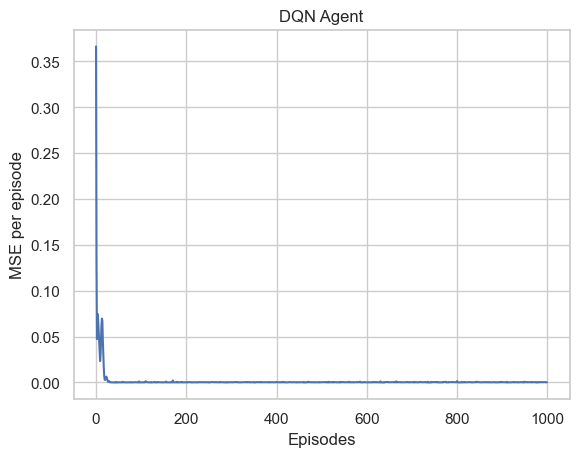

In [18]:
plot_loss_per_episode(training_stats['episodes_mean_loss'], dqn_agent_normal.__class__.__name__, save_name_normal)

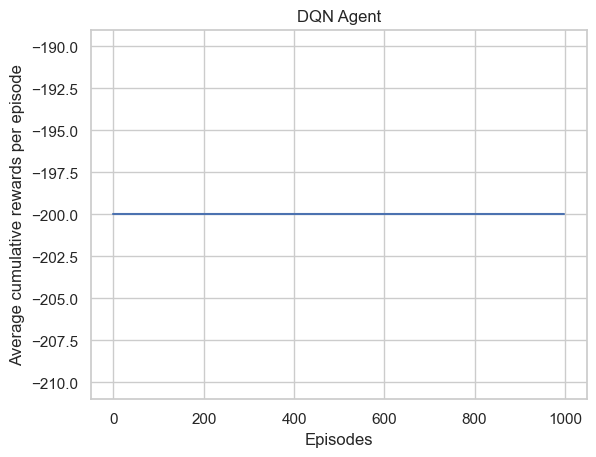

In [19]:
plot_mean_reward_per_episode(training_stats['episodes_rewards'], dqn_agent_normal.__class__.__name__, save_name_normal)

In [20]:
# Render
dqn_agent_render_normal = DQNAgent(trainable=False, save_name=save_name_normal)
_ = run(dqn_agent_render_normal, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


2. With more steps before truncation (1000 steps):

In [21]:
# Used to load/save the model
save_name_1000 = str(1000)

In [22]:
# DO NOT RUN IF YOU ONLY WANT TO RENDER
# Train the agent with normal truncation
dqn_agent_1000 = DQNAgent(trainable=True, save_name=save_name_1000)
training_stats = run(dqn_agent_1000, 1000, max_episode_steps=1000)

100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


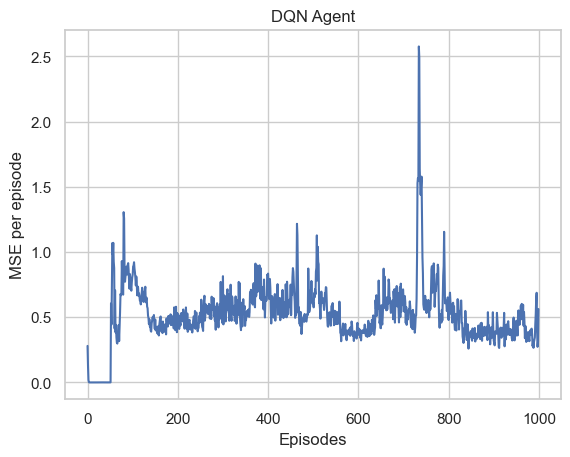

In [23]:
plot_loss_per_episode(training_stats['episodes_mean_loss'], dqn_agent_1000.__class__.__name__, save_name_1000)

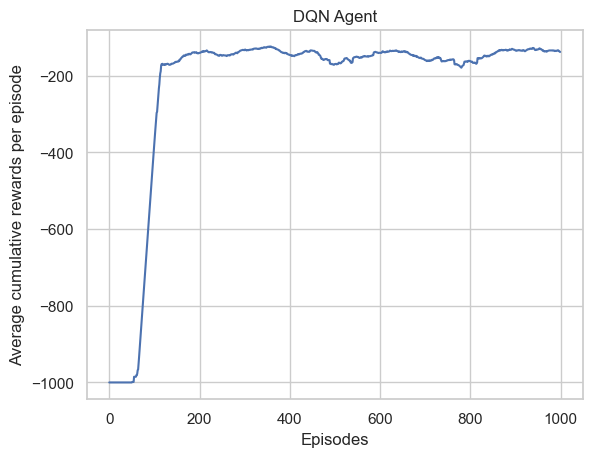

In [24]:
plot_mean_reward_per_episode(training_stats['episodes_rewards'], dqn_agent_1000.__class__.__name__, save_name_1000)

In [34]:
# Render
dqn_agent_render_1000 = DQNAgent(trainable=False, save_name=save_name_1000)
_ = run(dqn_agent_render_1000, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


#### Run DQN with domain-based reward function

In [26]:
# Used to load/save the model
save_name_domain_based = "domain_based"

In [27]:
dqn_agent_domain_based = DQNAgent(trainable=True, save_name=save_name_domain_based)
# Train on 3000 episodes (quite long)
domain_training_stats = run(dqn_agent_domain_based, 500, reward_function='domain-based', max_episode_steps=200)

100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


In [36]:
# Render
dqn_agent_render_domain_based = DQNAgent(trainable=False, save_name=save_name_domain_based)
_ = run(dqn_agent_render_domain_based, 1, render=True)

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


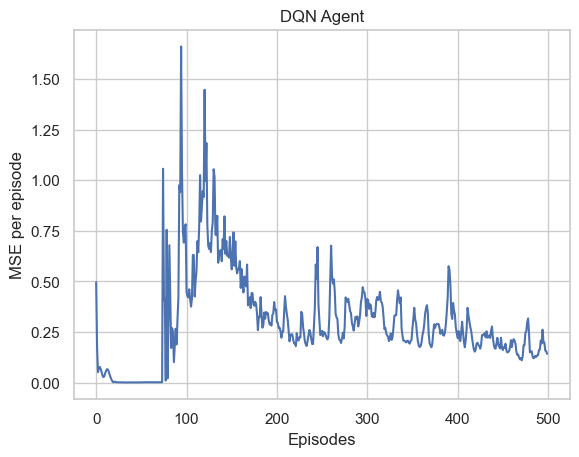

In [29]:
plot_loss_per_episode(domain_training_stats['episodes_mean_loss'], dqn_agent_1000.__class__.__name__, save_name_1000)

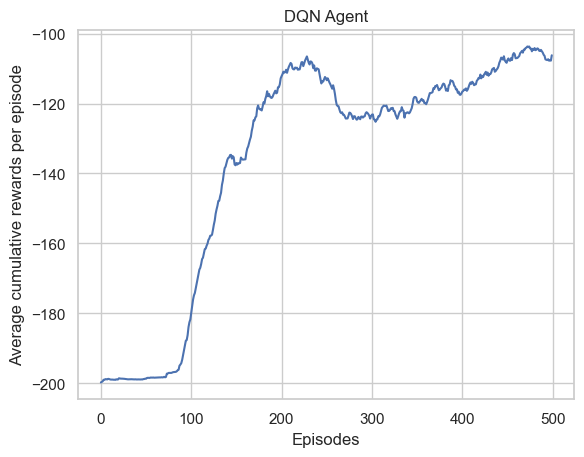

In [30]:
plot_mean_reward_per_episode(domain_training_stats['episodes_rewards'], dqn_agent_1000.__class__.__name__, save_name_1000)

In [31]:
domain_training_stats['num_successes']

391